# 1

In [1]:
!pip install tensorflow==2.5.0 opencv-python matplotlib

In [2]:
#General dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

#Tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# This sets GPU growth to avoid memory issues

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

# No tengo GPU? XD

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
pos_dir = os.path.join("data", "positive")
neg_dir = os.path.join("data", "negative")
anc_dir = os.path.join("data", "anchor")


# This one's for later :)
ver_dir = os.path.join("App_data", "Verification imgs")

In [5]:
# os.makedirs(pos_dir)
# os.makedirs(neg_dir)
# os.makedirs(anc_dir)

# 2

In [6]:
# Location of training images

# http://vis-www.cs.umass.edu/lfw/#download

In [7]:
# Extracts the imgs

# !tar -xf lfw.tgz # This name is now different

In [8]:
# for directory in os.listdir("lfw"):
#     for img in os.listdir(os.path.join("lfw", directory)):
#         old_path = os.path.join("lfw", directory, img)
#         new_path = os.path.join(neg_dir, img)
#         os.replace(old_path, new_path)

In [9]:
def take_center(frame):
    #Take the 250*250 center of the shape

    x = 195 # int((frame.shape[1])/2 - (250/2))
    y = 115 # int((frame.shape[0])/2 - (250/2))

    return frame[y:y+250, x:x+250]

In [10]:
import uuid

In [11]:
# Obtain anchor and positives

# cap = cv2.VideoCapture(0) # forwards cam is 0 !!

# while cap.isOpened():
#     _, frame = cap.read()
    
#     frame = take_center(frame)    
#     cv2.imshow("Image collection", frame)
    
#     # Collect positive
#     if cv2.waitKey(1) & 0XFF == ord("p"):
#         img_name = os.path.join(pos_dir, f"{uuid.uuid1()}.jpg")
#         cv2.imwrite(img_name, frame)
#         continue
        
#     # Collect anchor
#     if cv2.waitKey(1) & 0XFF == ord("a"):
#         img_name = os.path.join(anc_dir, f"{uuid.uuid1()}.jpg")
#         cv2.imwrite(img_name, frame)
#         continue
        
#     # Collect extra verification
#     if cv2.waitKey(1) & 0XFF == ord("v"):
#         img_name = os.path.join(ver_dir, f"{uuid.uuid1()}.jpg")
#         cv2.imwrite(img_name, frame)
#         continue
        
#     # Close camera
#     if cv2.waitKey(1) & 0XFF == ord("q"):
#         break

# cap.release()
# cv2.destroyAllWindows()

# 3

In [12]:
anchor = tf.data.Dataset.list_files(anc_dir+"\*.jpg").take(300)
positive = tf.data.Dataset.list_files(pos_dir+"\*.jpg").take(300)
negative = tf.data.Dataset.list_files(neg_dir+"\*.jpg").take(300)

In [13]:
# (anchor, positives) --> [1. 1. 1. 1. 1.] Verified images
# (anchor, negatives) --> [0. 0. 0. 0. 0.] Unverified images

In [14]:
# Creating the labeled datasets !

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [15]:
samplescheck = data.as_numpy_iterator()

In [16]:
samplescheck.next()

(b'data\\anchor\\f03937af-96c4-11ed-83e3-a4b1c185feb6.jpg',
 b'data\\positive\\b0122090-9c0e-11ed-a314-00919e4ce220.jpg',
 1.0)

In [17]:
def preprocess(file_path):
    # Adjusts images from file path into jpeg format
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    
    return img

In [18]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [19]:
samplescheck = data.as_numpy_iterator()

1.0


<Figure size 640x480 with 0 Axes>

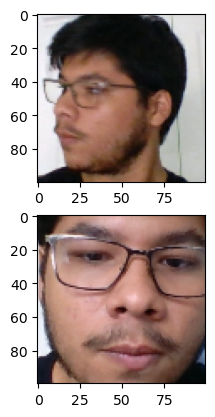

In [20]:
plt.figure()

_, axs = plt.subplots(2,1)


checky = samplescheck.next()

axs[0].imshow(preprocess(checky[0]))
axs[1].imshow(preprocess(checky[1]))

print(checky[2])

In [21]:
# Data loader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [22]:
# Training partition

train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
# Testing partition

test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [24]:
samples_check = train_data.as_numpy_iterator()

In [25]:
len(samples_check.next()[0])

16

# 4

In [26]:
# Build embedding layer

def make_embedding():
    input_layer = Input(shape=(100,100,3), name="Input image")
    
    # First block
    conv_layer1 = Conv2D(64, (10,10), activation="relu")(input_layer)
    maxp_layer1 = MaxPooling2D(64, (2,2), padding="same")(conv_layer1)
    
    # Second block
    conv_layer2 = Conv2D(128, (7,7), activation="relu")(maxp_layer1)
    maxp_layer2 = MaxPooling2D(64, (2,2), padding="same")(conv_layer2)
    
    # Third block
    conv_layer3 = Conv2D(128, (4,4), activation="relu")(maxp_layer2)
    maxp_layer3 = MaxPooling2D(64, (2,2), padding="same")(conv_layer3)
    
    # Final block
    conv_layer4 = Conv2D(256, (4,4), activation="relu")(maxp_layer3)
    flat1 = Flatten()(conv_layer4)
    dense1 = Dense(4096, activation="sigmoid")(flat1)
    
    
    return Model(inputs=[input_layer], outputs=[dense1], name="Embedding")  

In [27]:
embedding = make_embedding()

In [28]:
#Build distance layer

class L1Dist(Layer):
    # Inherits the "Layer" class's __init__()
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [29]:
def make_siamese_model():
    
    # Anchor image input
    input_image = Input(name="Input image", shape=(100,100,3))
    # Validation image input
    validation_image = Input(name="Validation image", shape=(100,100,3))
    
    # Combine siamese distance components
    
    siamese_layer = L1Dist()
    siamese_layer._name = "Distance"
    
    # Both streams are created AND connected down here ↓
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")

In [30]:
siamese_model = make_siamese_model()

# 5

In [31]:
# Loss function + optimizer
# Back propagation ← ← ←
# Checkpoints
# Train step function !!!
# Training loop

In [32]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [33]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "chkpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=siamese_model)

In [35]:
# Train step function !!

@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative
        x = batch[:2]
        # Get the label
        y_true = batch[2]
        
        # Forward pass
        y_pred = siamese_model(x, training=True)
        
        # Calculate loss
        loss = binary_cross_loss(y_true, y_pred)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    

In [38]:
# Training loop

def train(data, all_epochs):
    # Loop through all epochs
    for epoch in range(1, all_epochs+1):
        print(f"\n Epoch {epoch}/{all_epochs}")
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each BATCH!
        for index, batch in enumerate(data):
            train_step(batch)
            progbar.update(index + 1)
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [39]:
# TRAIN TIME BABYYY

Epochs = 50
train(train_data, Epochs)


 Epoch 1/50
27/27 [==============================] - 10s 169ms/step

 Epoch 2/50
27/27 [==============================] - 4s 155ms/step

 Epoch 3/50
27/27 [==============================] - 4s 155ms/step

 Epoch 4/50
27/27 [==============================] - 4s 155ms/step

 Epoch 5/50
27/27 [==============================] - 4s 154ms/step

 Epoch 6/50
27/27 [==============================] - 4s 154ms/step

 Epoch 7/50
27/27 [==============================] - 4s 154ms/step

 Epoch 8/50
27/27 [==============================] - 4s 155ms/step

 Epoch 9/50
27/27 [==============================] - 4s 158ms/step

 Epoch 10/50
27/27 [==============================] - 4s 157ms/step

 Epoch 11/50
27/27 [==============================] - 4s 157ms/step

 Epoch 12/50
27/27 [==============================] - 4s 158ms/step

 Epoch 13/50
27/27 [==============================] - 4s 156ms/step

 Epoch 14/50
27/27 [==============================] - 4s 159ms/step

 Epoch 15/50
27/27 [=====================

# <3

# 6

In [40]:
from tensorflow.keras.metrics import Precision, Recall

In [41]:
test_input, test_validation, y_true = test_data.as_numpy_iterator().next()

In [42]:
# siamese_model = model

In [43]:
y_predict = siamese_model.predict([test_input, test_validation])

In [44]:
y_predict

array([[1.0000000e+00],
       [2.6151665e-09],
       [1.0000000e+00],
       [5.8998743e-11],
       [3.4418163e-06],
       [9.9741215e-01],
       [9.9998951e-01],
       [1.2165958e-04],
       [9.9999940e-01],
       [3.9720291e-07],
       [1.1053842e-04],
       [1.3335717e-04],
       [9.9999928e-01],
       [9.9999940e-01],
       [2.4287992e-09],
       [5.3167360e-06]], dtype=float32)

In [45]:
small_pred = [1 if prediction > 0.5 else 0 for prediction in y_predict]

In [46]:
y_true

array([1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [47]:
m = Recall()

m.update_state(y_true, y_predict)
m.result().numpy()

1.0

In [48]:
m = Precision()

m.update_state(y_true, y_predict)
m.result().numpy()

1.0

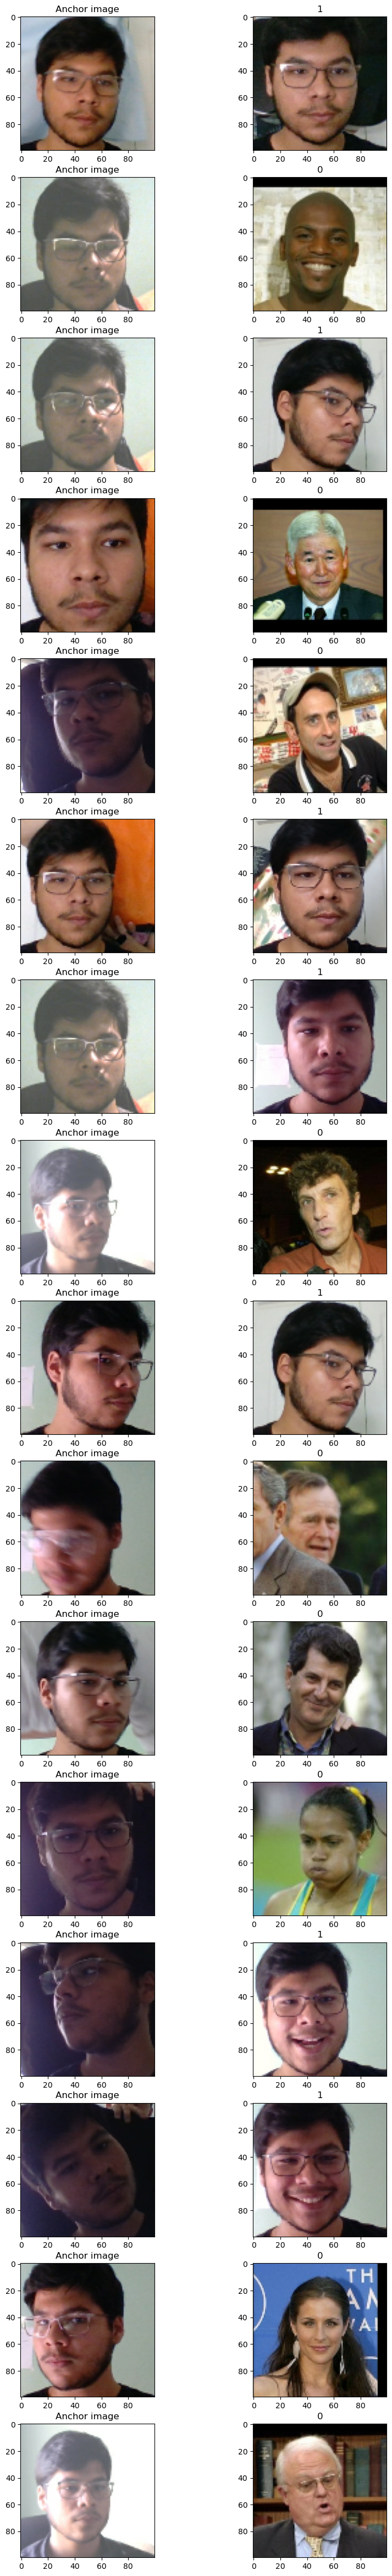

In [49]:
# print("Predicted value: ",y_predict[0][0])
batch_size = 16
_, axs = plt.subplots(batch_size,2)

for a in range(batch_size):
    axs[a][0].title.set_text("Anchor image")
    axs[a][0].imshow(test_input[a])
    axs[a][1].title.set_text(small_pred[a])
    axs[a][1].imshow(test_validation[a])

plt.gcf().set_size_inches(10, 60)
plt.show()

In [50]:
# Save weights

siamese_model.save("SiameseModel.h5")

In [51]:
# Break in case of emergency!

# checkpoint_dir = "./training_checkpoints"
# checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=siamese_model)

# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=10)
# checkpoint.restore(manager.latest_checkpoint)

# checkpoint.siamese_model.save("SiameseModel.h5")

In [56]:
model = tf.keras.models.load_model("V4-WORKING.h5",
                                   custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy": tf.losses.BinaryCrossentropy}) 

# 7

In [57]:
def verify(model, detection_thresh, verification_thresh):
    
    results = []
    for img in os.listdir(os.path.join("App_data","Verification imgs")):
        input_img = preprocess(os.path.join("App_data", "Input imgs", "input_image.jpg"))
        anchor_img = preprocess(os.path.join("App_data", "Verification imgs", img))
        
        prediction = model.predict(list(np.expand_dims([input_img, anchor_img], axis=1)))
        results.append(prediction[0][0]) # Predictions are 2D, single value arrays
        
    # Detection threshold: above this, it's positive    
    detection = np.sum(np.array(results) > detection_thresh)
    
    # Verification threshold --> Positive predictions / total positives (samples)
    verification = detection / len(os.listdir(os.path.join("App_data", "Verification imgs")))
    verified = verification > verification_thresh
    
    
    return np.array(results), verified

In [59]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _, frame = cap.read()
    
    frame = take_center(frame)
    cv2.imshow("Verification", frame)
    
    # Trigger verify
    if cv2.waitKey(10) & 0XFF == ord("v"):
        cv2.imwrite(os.path.join("App_data", "Input imgs", "input_image.jpg"), frame)
        results, verified = verify(model, 0.8, 0.8)
        print(verified)
        print(results)
        print(results.mean())
        continue
    
    # Close camera
    if cv2.waitKey(1) & 0XFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

False
[4.8598024e-01 1.6138120e-01 2.5164428e-01 6.6524027e-03 1.7765829e-01
 1.3167426e-01 4.3142110e-04 1.6549972e-01 1.0073008e-03 5.6726420e-01
 2.1882476e-02 3.2663658e-01 1.4394224e-02 9.4746715e-01 2.7759847e-01
 1.8210661e-01 2.1353427e-01 5.0581998e-01 7.8903884e-01 1.3472889e-01
 1.6137256e-01 1.5788268e-01 1.2104001e-02 8.0755982e-04 9.7653549e-04
 1.3115817e-03 9.9919862e-01 9.9863786e-01 9.9888486e-01 9.9905962e-01
 9.9905962e-01 9.9881858e-01 9.9881858e-01 3.1265533e-01 9.9861574e-01
 1.6815620e-03 7.0878968e-04 6.6290307e-04 5.6034903e-04 6.8535778e-04
 4.1003784e-04 4.2731868e-04 4.6933354e-03 9.7822040e-01]
0.34065124
True
[0.9665722  0.8328996  0.9002111  0.99105525 0.90708905 0.804458
 0.99691665 0.8554899  0.9192354  0.9805234  0.99801135 0.99998915
 0.99997187 0.99903286 0.99993205 0.8653228  0.8918404  0.97533256
 0.99360657 0.95511335 0.99999976 0.9999999  0.99999845 0.9999598
 0.9999603  0.9999713  0.9998154  0.9999572  0.9998355  0.9999101
 0.9999101  0.9999506